# ARMA(p,q)($q\geq1$)のモデルで作成されたinnovationを推定できるかどうかを確かめる。

## 動機
そもそも$q=0$のモデルを仮定してinnovationを推定し変化点検知をすると言うのでは、ただの予測誤差に夜変化点検知と何にも変わらない。

やはり最終的にはinnovation自体も複雑に絡み合って$X_t$が生成される、そう言うモデルのinnovationを推定したい。

それが可能かどうかを確かめる。

## 実験概要
### まずは$ARMA(p,q\geq1)$モデルで確かめる。
- $ARMA(p,q\geq1)$に従うモデルを作成
- このモデルから作成された人工データから正確にinnovationが推定できるかどうか
- 推定するにはどのくらいの$\hat p$の値が必要なのか

評価はinnovationの推定値と正解との平均二乗誤差とする。

### 非線形でinnovation系列もバラバラに組み合わせたモデルを作成して確かめる。

## 実験詳細
ここで確認しながらつめる。

In [1]:
import argparse
import os
path = os.getcwd()
path=path[:path.find('estimate-innovation')+20]
# No = (os.path.basename(__file__))[-4]
No = "0" # notebook用
# print('実験No.'+No)
import warnings
warnings.simplefilter('ignore')# 警告を非表示
import numpy as np
np.set_printoptions(precision=4, floatmode='fixed', suppress=True)
import matplotlib.pyplot as plt
from scipy import stats
import math
import sys
sys.path.append(path)
import random
import time
import statsmodels.api as sm
from scipy.stats import norm
import japanize_matplotlib
from scipy.stats import gaussian_kde

import torchvision.transforms as transforms
from torchvision.utils import save_image

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.autograd import Variable
# 人工データを生成してくれる機械が置いてあるところ
import tsModel
# 学習用のニューラルネットが置いてあるところ
# import models
# p-Wasserstein距離の関数
# import Wasserstein

### ARMAモデルの作成と可視化

In [2]:
phi_a = [1.0, -0.5, 0.7, -0.4]
phi_b = [1.0, -0.7]
p = len(phi_a)
q = len(phi_b)
dataSeed=5
N = 1000
data = tsModel.ARIMA(a=phi_a, b=phi_b, N=N, random_seed=dataSeed, randomness='normal')
inno = tsModel.ARIMA(a=phi_a, b=phi_b, N=N, random_seed=dataSeed, randomness='normal', return_innovation=True)

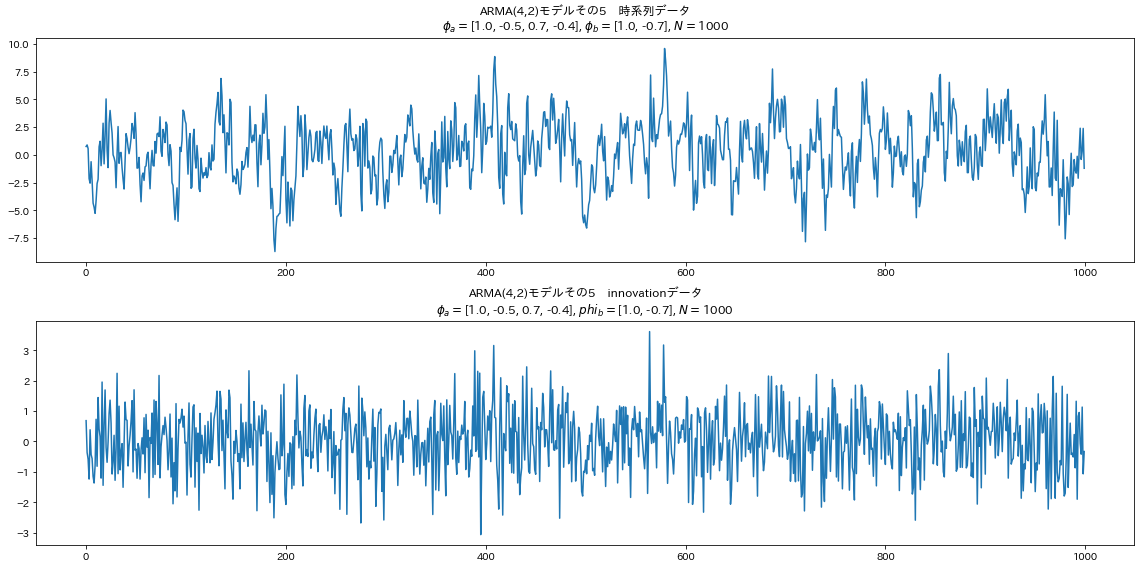

In [3]:
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.plot(data, label ='data')
ax2.plot(inno, label ='innovation')
ax1.title.set_text('ARMA({0},{1})モデルその{2}　時系列データ'.format(p,q,dataSeed) + '\n$\phi_a=${0}, $\phi_b=${1}, $N=${2}'.format(phi_a,phi_b,N))
ax2.title.set_text('ARMA({0},{1})モデルその{2}　innovationデータ'.format(p,q,dataSeed) + '\n$\phi_a=${0}, $phi_b=${1}, $N=${2}'.format(phi_a,phi_b,N))
plt.tight_layout()
plt.savefig('./images/ARMA{0}-{1}sample.png'.format(p,q))


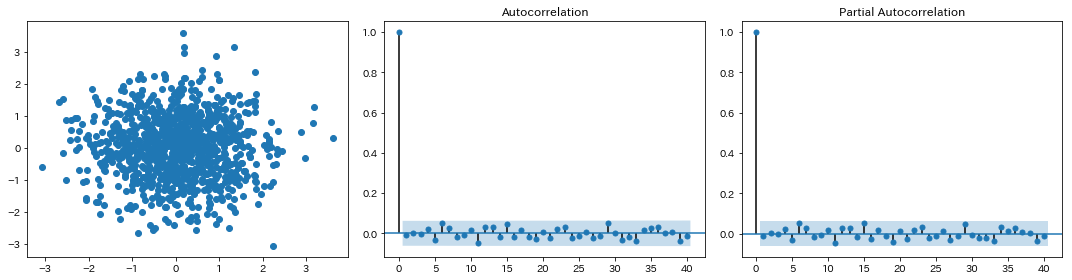

In [4]:
# 一時刻差のラグプロットと自己相関係数(innovationの独立性の確認)
fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)
ax1.scatter(inno[:-1], inno[1:])
sm.graphics.tsa.plot_acf(inno, ax=ax2, lags=40)
sm.graphics.tsa.plot_pacf(inno, ax=ax3, lags=40)
plt.tight_layout()

発散もしてないし、innoも独立なので、
とりあえずこのモデルで良さそう。

### 対象実験として、$AR(\hat p)$を仮定してモデリングをした、その残渣系列のMSEをみる

In [5]:
from statsmodels.tsa.ar_model import ar_select_order

In [6]:
# ARモデルにおけるの次数をaicで推定
mod = ar_select_order(data, maxlag=13)
mod.ar_lags

array([1, 2, 3, 4, 5, 6])

In [7]:
# ARモデルの係数を学習
from statsmodels.tsa.ar_model import AutoReg
res = AutoReg(data, lags = mod.ar_lags).fit()

In [8]:
res.params

array([ 0.0651,  1.1834, -1.0195,  1.2137, -0.8426,  0.4025, -0.1591])

2.1755664633130585


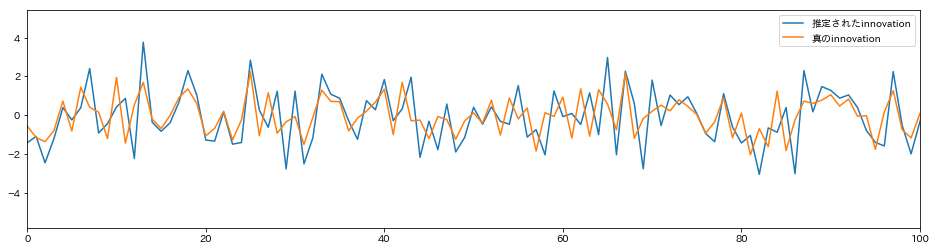

In [9]:
# 訓練データにおける予測誤差と真のinnovationの値を比較
plt.figure(figsize=(16,4))
plt.plot(data[6:]-res.predict(), label='推定されたinnovation')
plt.plot(inno[6:], label='真のinnovation')
plt.legend()
plt.xlim([0,100])
print(((data[6:]-res.predict())**2).sum()/len(data[6:]))

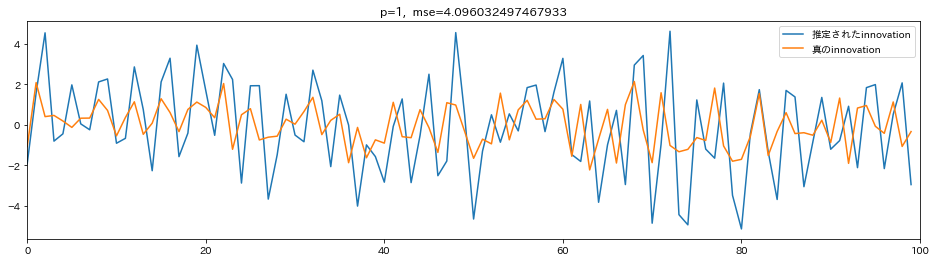

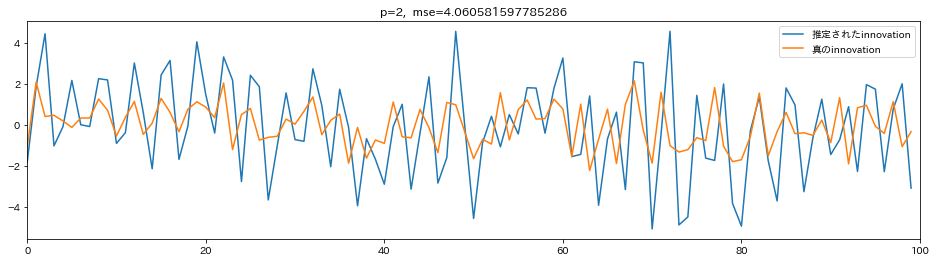

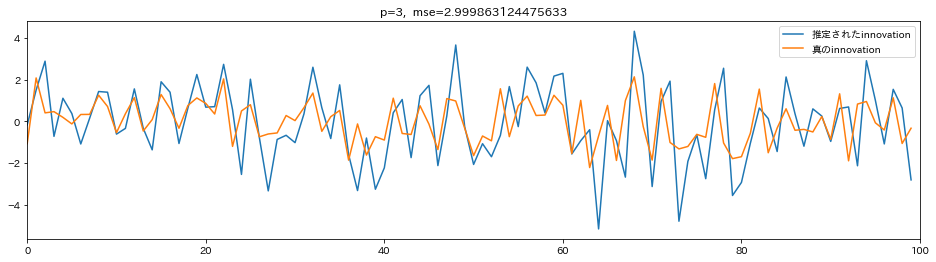

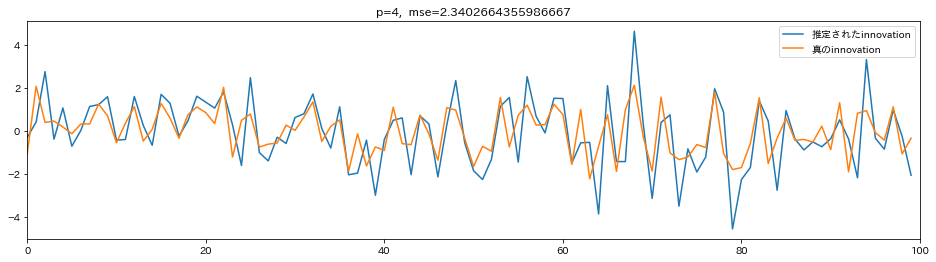

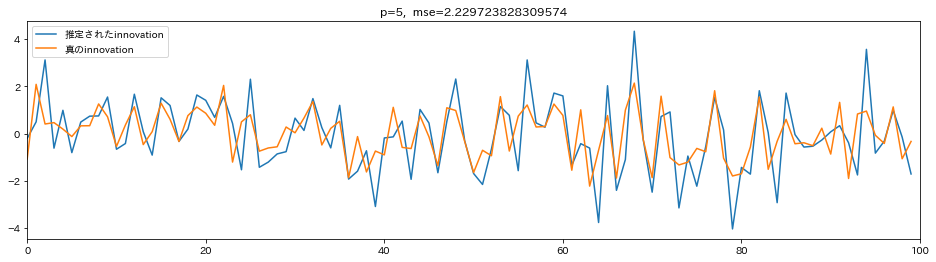

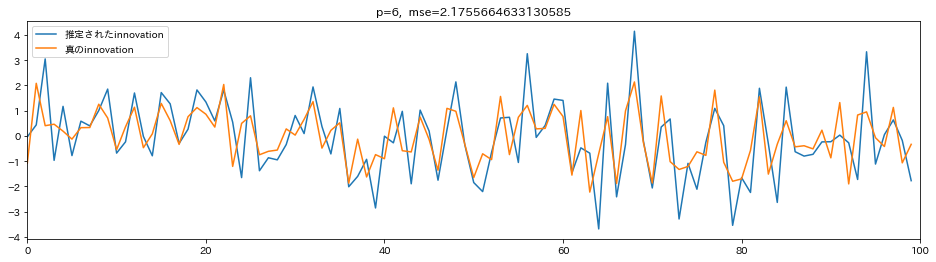

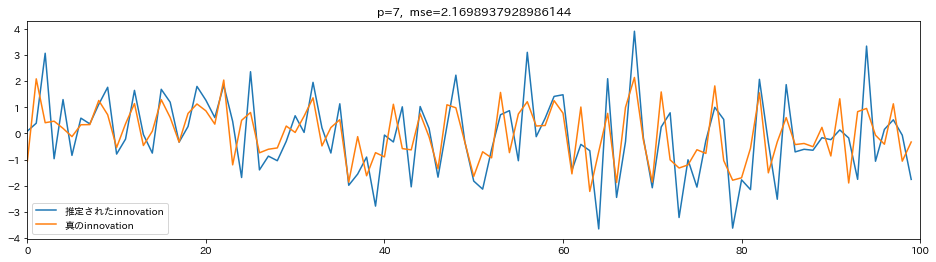

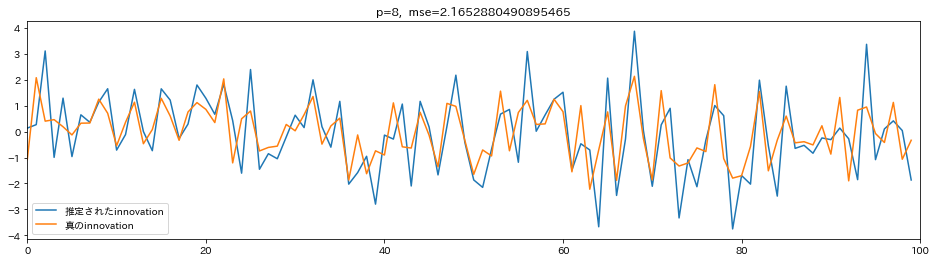

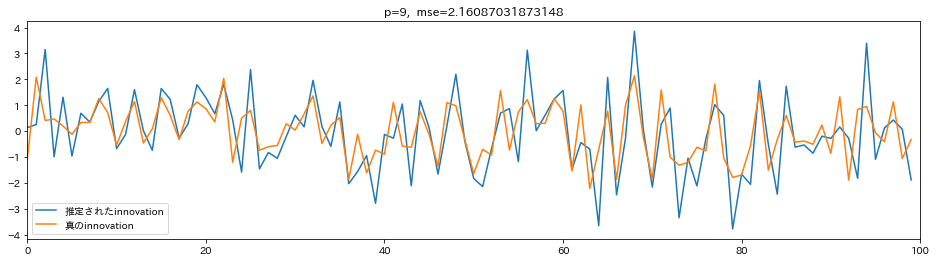

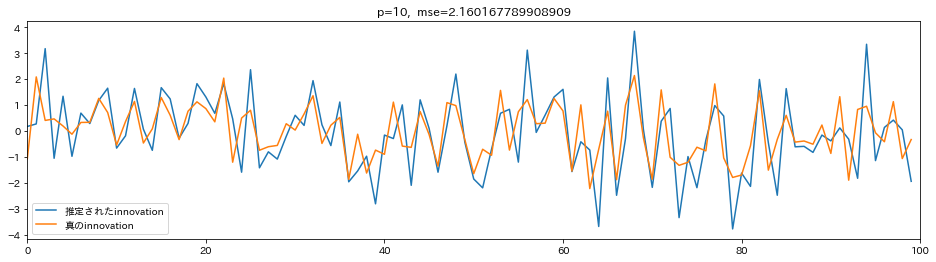

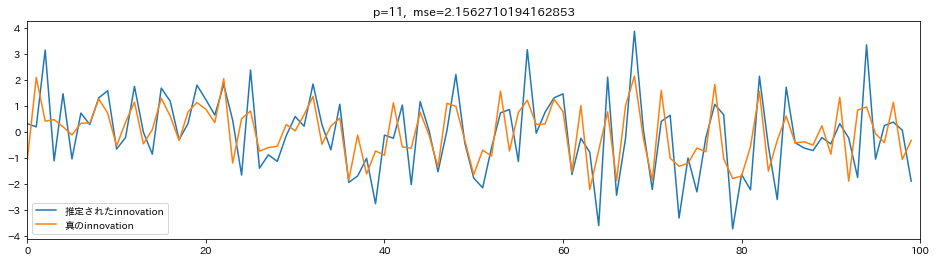

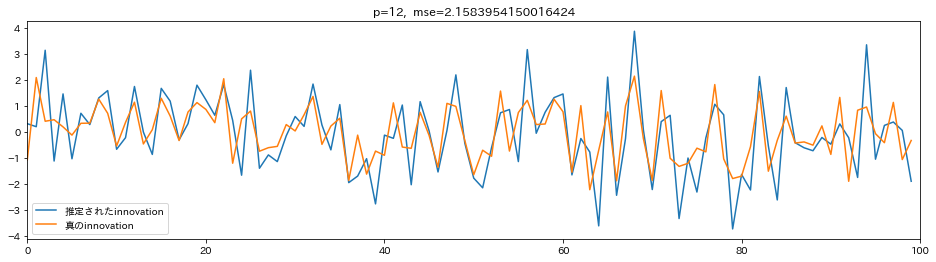

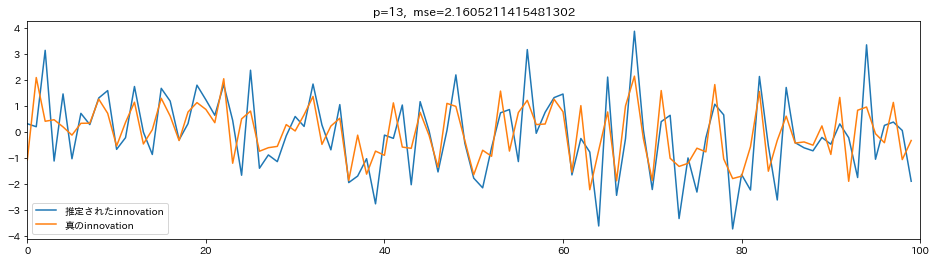

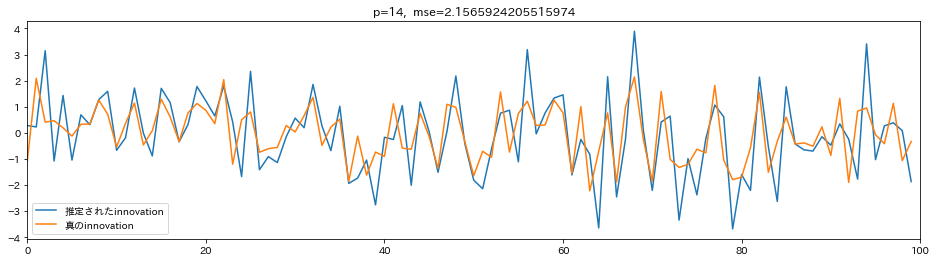

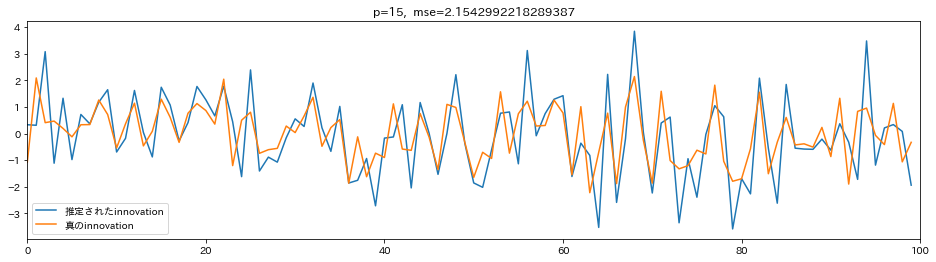

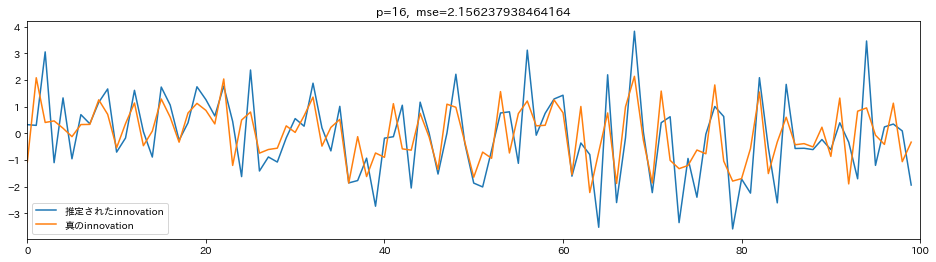

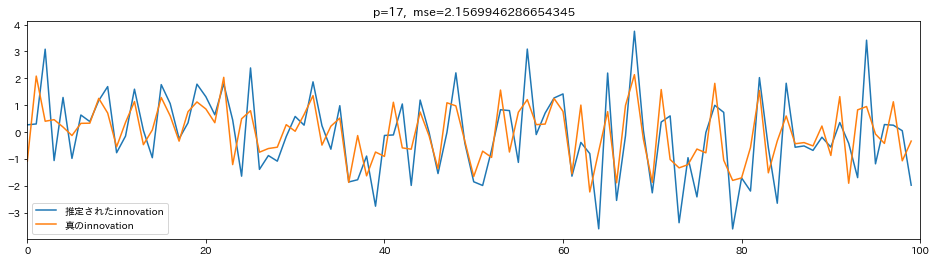

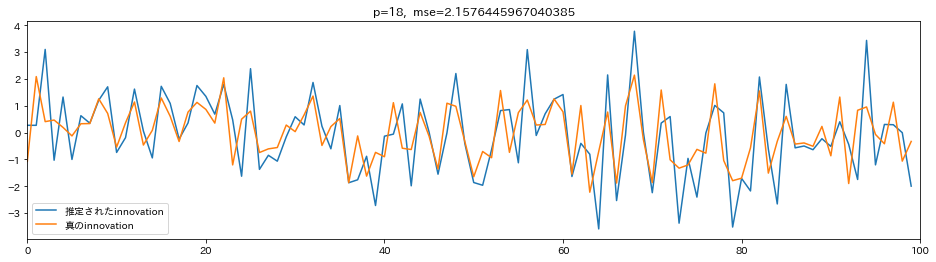

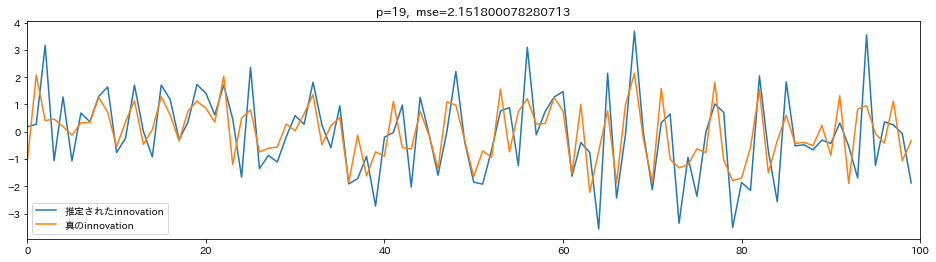

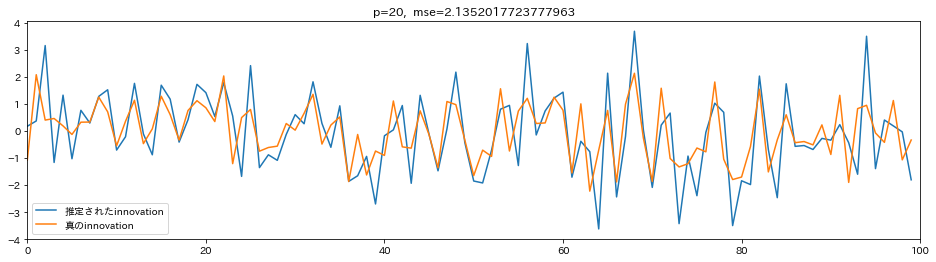

In [10]:
# ARモデルの次数を1から20まで変化させた場合
mse = []
for p in range(1,21):
    res = AutoReg(data, lags = p).fit()
    plt.figure(figsize=(16,4))
    plt.plot((data[p:]-res.predict())[-100:], label='推定されたinnovation')
    mse.append( ((data[p:]-res.predict())**2).sum()/len(data[p:]) )
    plt.plot(inno[-100:], label='真のinnovation')
    plt.legend()
    plt.xlim([0,100])
    plt.title("p={0},  mse={1}".format(p, mse[-1]))
    plt.savefig("/home/lab/ryuichi/Downloads/plot{0}.png".format(p))
    plt.show()

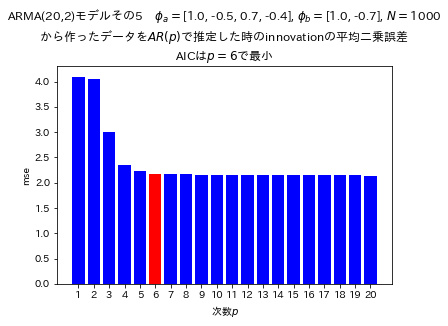

In [11]:
plt.bar(range(1,len(mse)+1), mse, align="center", color=['red' if i+1==mod.ar_lags[-1] else 'blue' for i in range(20)])
plt.xticks(range(1,len(mse)+1))
plt.xlabel("次数$p$")
plt.ylabel('mse')
plt.title('ARMA({0},{1})モデルその{2}　'.format(p,q,dataSeed) + '$\phi_a=${0}, $\phi_b=${1}, $N=${2}'.format(phi_a,phi_b,N)+"\nから作ったデータを$AR(p)$で推定した時のinnovationの平均二乗誤差\nAICは$p={0}$で最小".format(mod.ar_lags[-1]))
plt.savefig("./images/ARMA{0}-{1}_inno-MSE_barplot.png".format(p,q), bbox_inches="tight")

# 非線形ARで同じARMAモデル時系列を推定してちゃんとmseが下がるかどうか

In [5]:
p=4
q=2

In [6]:
# 学習する推定モデルの形状や学習方法なんかを決定します
# 学習時のハイパラの決定（入力を受け付ける）
parser = argparse.ArgumentParser()
# ランダムシードについて
parser.add_argument("--generator_seed", type=int, default=0, help="generatorのパラメータの初期値のシード")
parser.add_argument("--discriminator_seed", type=int, default=0, help="discriminatorのパラメータの初期値のシード")
parser.add_argument("--predictor_seed", type=int, default=0, help="predictorのパラメータの初期値のシード")
parser.add_argument("--training_seed", type=int, default=0, help="訓練データを学習させる順番を決めるシード")
parser.add_argument("--data_seed", type=int, default=0, help="Dataの作成に用いる乱数のseed")
# 学習方法について
parser.add_argument("--n_epochs", type=int, default=2000, help="Discriminatorを学習させる回数")
parser.add_argument("--batch_size", type=int, default=64, help="batchの大きさ")
parser.add_argument("--lr", type=float, default=0.00005, help="学習率")
parser.add_argument("--n_critic", type=int, default=5, help="一度generatorを更新するごとに何回discriminatorを更新するか")
parser.add_argument("--discriminator_hidden_unit", type=int, default=64, help="discriminatorの隠れ層のニューロンの数")
# parser.add_argument("--withGP", type=bool, default=True, help="clipingの代わりにGradient Penaltyを加えるかどうか。True/False")
# parser.add_argument("--withCorr", type=bool, default=True, help="Generatorの出力がbatch方向に無相関になるようなロスを加えるかどうか。　True/False")
# モデルの保存やLossの可視化について
parser.add_argument("--sample_interval", type=int, default=100, help="epochを何回まわす度にモデルの保存を行うか")

try:
    opt = parser.parse_args() # .pyの場合はこちらを使用(.ipynbの場合エラーになります)
except:
    opt = parser.parse_args(args=[]) # .ipynbの場合はこちらを使用
print(opt)

Namespace(batch_size=64, data_seed=0, discriminator_hidden_unit=64, discriminator_seed=0, generator_seed=0, lr=5e-05, n_critic=5, n_epochs=2000, predictor_seed=0, sample_interval=100, training_seed=0)


usage: ipykernel_launcher.py [-h] [--generator_seed GENERATOR_SEED]
                             [--discriminator_seed DISCRIMINATOR_SEED]
                             [--predictor_seed PREDICTOR_SEED]
                             [--training_seed TRAINING_SEED]
                             [--data_seed DATA_SEED] [--n_epochs N_EPOCHS]
                             [--batch_size BATCH_SIZE] [--lr LR]
                             [--n_critic N_CRITIC]
                             [--discriminator_hidden_unit DISCRIMINATOR_HIDDEN_UNIT]
                             [--sample_interval SAMPLE_INTERVAL]
ipykernel_launcher.py: error: unrecognized arguments: -f /run/user/1165/jupyter/kernel-5354b8b9-7b07-4121-88e8-9dd6abb2ef04.json


In [7]:
os.makedirs("output-images/p{0}".format(p), exist_ok=True)
os.makedirs("parameters/p{0}".format(p), exist_ok=True)

In [8]:
import checkGPU
cuda, device = checkGPU.checkGPU()

GPUは使えません。


In [9]:
import models
torch.manual_seed(opt.generator_seed)
generator = models.Generator(p = p, q=q)

In [10]:
a= torch.rand([33,1,p+1])# 最初はバッチサイズ
print("input size   :",a.shape)
b = generator(a)
print("output size:",b.shape)

input size   : torch.Size([33, 1, 5])
output size: torch.Size([33, 3])


In [11]:
torch.manual_seed(opt.predictor_seed)
predictor = models.predictNet(p=p, q=q)

In [12]:
a= torch.rand([33,1,p+q+1])# 最初はバッチサイズ
print("input size   :",a.shape)
b = predictor(a)
print("output size:",b.shape)

input size   : torch.Size([33, 1, 7])
output size: torch.Size([33, 1, 1])


In [13]:
torch.manual_seed(opt.discriminator_seed)
discriminator = models.Discriminator(q=q, discriminator_hidden_unit=64)

In [14]:
# 入出力の大きさの確認
a = torch.rand([11, q+1])
print("input size   :",a.shape)
b = discriminator(a, is_from_generator=True)
print("output size:",b.shape)

input size   : torch.Size([11, 3])
output size: torch.Size([11, 1])


In [15]:
# 訓練データを一つ用いて学習させる
# dataSeed=opt.data_seed
# こいつをtrain:validation=900:100に分割する
Data = data.copy()
Data = torch.tensor(Data, dtype=torch.float)
Data=Data.view(1,-1)
trainData = Data[:,:900]
valData = Data[:,900:]

In [16]:
# trainDataとvalDataを {𝑋𝑡}𝑡0𝑡=𝑡0−𝑝 ごとに取り出しやすいようにMatrixに変換する
trainMatrix = []
for i in range(trainData.shape[1]-(p)):
    ans = trainData[:,i:i+p+1].view(1,Data.shape[0],-1)
    trainMatrix.append(ans)
trainMatrix = torch.cat(trainMatrix)
valMatrix = []
for i in range(valData.shape[1]-(p)):
    ans = valData[:,i:i+p+1].view(1,Data.shape[0],-1)
    valMatrix.append(ans)
valMatrix = torch.cat(valMatrix)

In [21]:
# Optimizers(パラメータに対して定義される)
optimizer_G = torch.optim.RMSprop(params=generator.parameters(), lr=opt.lr)
# optimizer_D = torch.optim.RMSprop(params=discriminator.parameters(), lr=opt.lr)
# optimizer_F = torch.optim.RMSprop(params=predictor.parameters(), lr=opt.lr)
optimizer_F = torch.optim.Adam(params=predictor.parameters(), lr=0.0005 )

# 二条誤差MSE
mseLoss = nn.MSELoss()

# パラメータと学習データをGPUに乗っける
generator.to(device)
# discriminator.to(device)
predictor.to(device)
trainMatrix=trainMatrix.to(device)
valMatrix=valMatrix.to(device)
mseLoss.to(device)

saveModel = input('作成したモデルを {0} epochごとに逐次保存しますか？ （Yes：1, No：0）  ----> '.format(opt.sample_interval))
saveModel = bool(int(saveModel))

作成したモデルを 100 epochごとに逐次保存しますか？ （Yes：1, No：0）  ----> 1


In [ ]:
# 訓練データの時系列のどの時刻を学習に用いるかをランダムにしているが、そのランダムシードを固定する
random.seed(a=opt.training_seed)

do_preTrain = bool(int(input('事前学習をここで行いますか、それとも読み込みますか （行う：1, 読み込む：0）  ----> ')))
pretrain_param = 'parameters/p{0}/No{1}_predictor_epoch{2}_batchSize{3}_DataSeed{4}.pth'.format(p, No, 0, opt.batch_size, dataSeed )
if not do_preTrain:
    try:# モデルパラメータを読み込もうとして失敗したら、それはファイルがないと言うことなので、事前学習をこの場で行う
        predictor.load_state_dict(torch.load(pretrain_param)) 
    except:
        print("モデルが存在しないので事前学習を行います")
        do_preTrain=True

if do_preTrain:
    # ここでまずはFの事前学習を行う
    loss_pre = []
    val_loss_pre = []
    pretrain_epoch = 2000
    start=time.time()
    for epoch in range(1, pretrain_epoch+1):# epochごとの処理
        # batchの処理は、0~892をランダムに並び替えたリストbatch_sampleを作成し、ここからbatch×(p+1)の学習データを一つづつ獲得する
        l=list(range(trainMatrix.shape[0]-opt.batch_size))
        batch_sample = random.sample(l, len(l))
        for i, batch in enumerate(batch_sample):
            X = trainMatrix[batch : batch+opt.batch_size]# torch.Size([64, 1, p+1]) (batch, dim, p+1)
            optimizer_F.zero_grad()
            input_tensor = X[:,:,:-1]
            input_tensor = torch.cat([torch.randn([opt.batch_size,1,q+1]).to(device), input_tensor], dim=2)
#             input_tensor = torch.cat([torch.ones([opt.batch_size,1,q+1]).to(device), input_tensor], dim=2)
            true_tensor = X[:,:,-1]
            prediction = predictor(input_tensor)
            loss_F = mseLoss(prediction, true_tensor)
            loss_F.backward()
            optimizer_F.step()
        loss_pre.append(loss_F.item())
        
        val_input = torch.cat([torch.randn([valMatrix.shape[0],1,q+1]).to(device), valMatrix[:,:,:-1]], dim=2)
#         val_input = torch.cat([torch.ones([valMatrix.shape[0],1,q+1]).to(device), valMatrix[:,:,:-1]], dim=2)
        val_target = valMatrix[:,:,-1].view(valMatrix.shape[0], -1)
        val_loss = mseLoss(predictor(val_input), val_target)
        val_loss_pre.append(val_loss.item())
        
        print("epoch：{0}/{1}   loss_F：{2: .4f}   経過時間：{3: .1f}秒".format(epoch, pretrain_epoch, round(loss_F.item(), 4), time.time()-start))
        if epoch % 100==0:
            plt.figure(figsize=(13,8))
            plt.title("PredictorのLossの遷移　\n　batchSize:{0}".format(opt.batch_size))
            plt.xlabel("epoch")
            plt.ylabel("Loss")
            plt.plot(loss_pre, label="training")
            plt.plot(val_loss_pre, label="validation")
            plt.legend()
            plt.savefig("preloss.png")
            plt.close()
    torch.save(predictor.state_dict(), pretrain_param)
    
    plt.figure(figsize=(13,8))
    plt.title("PredictorのLossの遷移　\n　batchSize:{0}".format(opt.batch_size))
    plt.xlabel("epoch")
    plt.ylabel("Loss")
    plt.plot(loss_pre, label="training")
    plt.plot(val_loss_pre, label="validation")
    plt.legend()
    plt.savefig("output-images/p{0}/No{1}_preloss_epoch{2}_batchSize{3}_DataSeed{4}.png".format(p, No, epoch, opt.batch_size, dataSeed ))
    plt.close()
    print("pre-training終了")


事前学習をここで行いますか、それとも読み込みますか （行う：1, 読み込む：0）  ----> 1
epoch：1/5000   loss_F： 9.1441   経過時間： 2.1秒
epoch：2/5000   loss_F： 5.7052   経過時間： 4.1秒
epoch：3/5000   loss_F： 11.2571   経過時間： 6.2秒
epoch：4/5000   loss_F： 5.4250   経過時間： 8.2秒
epoch：5/5000   loss_F： 6.2599   経過時間： 10.3秒
epoch：6/5000   loss_F： 5.5747   経過時間： 12.4秒
epoch：7/5000   loss_F： 10.8718   経過時間： 14.4秒
epoch：8/5000   loss_F： 10.0656   経過時間： 16.5秒
epoch：9/5000   loss_F： 7.5040   経過時間： 18.6秒
epoch：10/5000   loss_F： 5.8678   経過時間： 20.6秒
epoch：11/5000   loss_F： 6.5695   経過時間： 22.7秒
epoch：12/5000   loss_F： 7.0183   経過時間： 24.8秒
epoch：13/5000   loss_F： 7.5035   経過時間： 26.8秒
epoch：14/5000   loss_F： 8.4414   経過時間： 28.9秒
epoch：15/5000   loss_F： 8.5615   経過時間： 31.0秒
epoch：16/5000   loss_F： 6.3588   経過時間： 33.0秒
epoch：17/5000   loss_F： 5.9704   経過時間： 35.1秒
epoch：18/5000   loss_F： 7.3129   経過時間： 37.2秒
epoch：19/5000   loss_F： 8.2923   経過時間： 39.2秒
epoch：20/5000   loss_F： 9.7240   経過時間： 41.3秒
epoch：21/5000   loss_F： 8.1478   経過時間： 43.4秒
epoch：22/5000  

epoch：178/5000   loss_F： 6.2497   経過時間： 368.7秒
epoch：179/5000   loss_F： 8.3529   経過時間： 370.8秒
epoch：180/5000   loss_F： 8.6388   経過時間： 372.8秒
epoch：181/5000   loss_F： 6.3580   経過時間： 374.9秒
epoch：182/5000   loss_F： 8.4822   経過時間： 376.9秒
epoch：183/5000   loss_F： 8.3083   経過時間： 379.0秒
epoch：184/5000   loss_F： 8.1202   経過時間： 381.1秒
epoch：185/5000   loss_F： 5.5629   経過時間： 383.1秒
epoch：186/5000   loss_F： 6.3255   経過時間： 385.2秒
epoch：187/5000   loss_F： 5.2832   経過時間： 387.3秒
epoch：188/5000   loss_F： 9.7975   経過時間： 389.3秒
epoch：189/5000   loss_F： 8.9064   経過時間： 391.4秒
epoch：190/5000   loss_F： 5.6353   経過時間： 393.4秒
epoch：191/5000   loss_F： 6.9438   経過時間： 395.5秒
epoch：192/5000   loss_F： 6.3287   経過時間： 397.5秒
epoch：193/5000   loss_F： 6.3407   経過時間： 399.6秒
epoch：194/5000   loss_F： 8.4549   経過時間： 401.7秒
epoch：195/5000   loss_F： 6.8736   経過時間： 403.7秒
epoch：196/5000   loss_F： 8.8947   経過時間： 405.8秒
epoch：197/5000   loss_F： 6.4965   経過時間： 407.9秒
epoch：198/5000   loss_F： 5.7509   経過時間： 409.9秒
epoch：199/500

epoch：352/5000   loss_F： 5.2978   経過時間： 727.2秒
epoch：353/5000   loss_F： 6.3493   経過時間： 729.3秒
epoch：354/5000   loss_F： 8.3871   経過時間： 731.3秒
epoch：355/5000   loss_F： 8.3507   経過時間： 733.4秒
epoch：356/5000   loss_F： 9.9690   経過時間： 735.5秒
epoch：357/5000   loss_F： 5.9172   経過時間： 737.6秒
epoch：358/5000   loss_F： 7.5851   経過時間： 739.6秒
epoch：359/5000   loss_F： 11.4430   経過時間： 741.7秒
epoch：360/5000   loss_F： 9.1088   経過時間： 743.8秒
epoch：361/5000   loss_F： 7.6970   経過時間： 745.8秒
epoch：362/5000   loss_F： 11.2086   経過時間： 747.9秒
epoch：363/5000   loss_F： 6.0773   経過時間： 750.0秒
epoch：364/5000   loss_F： 5.1388   経過時間： 752.1秒
epoch：365/5000   loss_F： 5.8477   経過時間： 754.1秒
epoch：366/5000   loss_F： 7.6853   経過時間： 756.2秒
epoch：367/5000   loss_F： 6.1142   経過時間： 758.3秒
epoch：368/5000   loss_F： 5.4996   経過時間： 760.4秒
epoch：369/5000   loss_F： 5.4005   経過時間： 762.4秒
epoch：370/5000   loss_F： 5.8823   経過時間： 764.5秒
epoch：371/5000   loss_F： 5.1200   経過時間： 766.6秒
epoch：372/5000   loss_F： 8.2892   経過時間： 768.6秒
epoch：373/5

epoch：526/5000   loss_F： 9.2628   経過時間： 1088.5秒
epoch：527/5000   loss_F： 5.1366   経過時間： 1090.6秒
epoch：528/5000   loss_F： 9.6771   経過時間： 1092.6秒
epoch：529/5000   loss_F： 7.6513   経過時間： 1094.7秒
epoch：530/5000   loss_F： 11.1609   経過時間： 1096.8秒
epoch：531/5000   loss_F： 5.2462   経過時間： 1098.8秒
epoch：532/5000   loss_F： 8.9968   経過時間： 1100.9秒
epoch：533/5000   loss_F： 6.7524   経過時間： 1103.0秒
epoch：534/5000   loss_F： 7.7216   経過時間： 1105.0秒
epoch：535/5000   loss_F： 7.1579   経過時間： 1107.0秒
epoch：536/5000   loss_F： 5.7180   経過時間： 1109.1秒
epoch：537/5000   loss_F： 7.5412   経過時間： 1111.2秒
epoch：538/5000   loss_F： 7.3643   経過時間： 1113.2秒
epoch：539/5000   loss_F： 5.0167   経過時間： 1115.3秒
epoch：540/5000   loss_F： 8.5225   経過時間： 1117.4秒
epoch：541/5000   loss_F： 5.6851   経過時間： 1119.5秒
epoch：542/5000   loss_F： 7.6410   経過時間： 1121.5秒
epoch：543/5000   loss_F： 9.9943   経過時間： 1123.6秒
epoch：544/5000   loss_F： 5.3127   経過時間： 1125.7秒
epoch：545/5000   loss_F： 8.3970   経過時間： 1127.7秒
epoch：546/5000   loss_F： 8.7538   経過時間：

epoch：697/5000   loss_F： 3.8643   経過時間： 1442.3秒
epoch：698/5000   loss_F： 7.3401   経過時間： 1444.4秒
epoch：699/5000   loss_F： 5.8858   経過時間： 1446.5秒
epoch：700/5000   loss_F： 7.7637   経過時間： 1448.6秒
epoch：701/5000   loss_F： 8.2712   経過時間： 1451.0秒
epoch：702/5000   loss_F： 7.3816   経過時間： 1453.0秒
epoch：703/5000   loss_F： 8.1630   経過時間： 1455.1秒
epoch：704/5000   loss_F： 11.0800   経過時間： 1457.2秒
epoch：705/5000   loss_F： 7.3523   経過時間： 1459.3秒
epoch：706/5000   loss_F： 7.4794   経過時間： 1461.3秒
epoch：707/5000   loss_F： 7.8255   経過時間： 1463.4秒
epoch：708/5000   loss_F： 10.2557   経過時間： 1465.5秒
epoch：709/5000   loss_F： 8.3699   経過時間： 1467.6秒
epoch：710/5000   loss_F： 8.7968   経過時間： 1469.6秒
epoch：711/5000   loss_F： 10.6336   経過時間： 1471.7秒
epoch：712/5000   loss_F： 7.5054   経過時間： 1473.8秒
epoch：713/5000   loss_F： 9.1119   経過時間： 1475.9秒
epoch：714/5000   loss_F： 11.4923   経過時間： 1477.9秒
epoch：715/5000   loss_F： 8.3076   経過時間： 1480.0秒
epoch：716/5000   loss_F： 9.9039   経過時間： 1482.1秒
epoch：717/5000   loss_F： 11.4527   経

epoch：868/5000   loss_F： 10.8168   経過時間： 1797.7秒
epoch：869/5000   loss_F： 5.8236   経過時間： 1799.8秒
epoch：870/5000   loss_F： 4.4716   経過時間： 1801.9秒
epoch：871/5000   loss_F： 7.2900   経過時間： 1804.0秒
epoch：872/5000   loss_F： 8.6464   経過時間： 1806.1秒
epoch：873/5000   loss_F： 9.3814   経過時間： 1808.2秒
epoch：874/5000   loss_F： 6.4655   経過時間： 1810.3秒
epoch：875/5000   loss_F： 8.5116   経過時間： 1812.4秒
epoch：876/5000   loss_F： 9.6248   経過時間： 1814.5秒
epoch：877/5000   loss_F： 7.5975   経過時間： 1816.6秒
epoch：878/5000   loss_F： 6.4069   経過時間： 1818.6秒
epoch：879/5000   loss_F： 6.4545   経過時間： 1820.7秒
epoch：880/5000   loss_F： 8.8490   経過時間： 1822.8秒
epoch：881/5000   loss_F： 5.4345   経過時間： 1824.9秒
epoch：882/5000   loss_F： 9.5080   経過時間： 1827.0秒
epoch：883/5000   loss_F： 10.5635   経過時間： 1829.0秒
epoch：884/5000   loss_F： 6.7732   経過時間： 1831.1秒
epoch：885/5000   loss_F： 9.3076   経過時間： 1833.2秒
epoch：886/5000   loss_F： 5.5359   経過時間： 1835.3秒
epoch：887/5000   loss_F： 9.1393   経過時間： 1837.4秒
epoch：888/5000   loss_F： 6.0886   経過時間

epoch：1038/5000   loss_F： 9.5357   経過時間： 2150.1秒
epoch：1039/5000   loss_F： 4.8030   経過時間： 2152.1秒
epoch：1040/5000   loss_F： 11.6352   経過時間： 2154.2秒
epoch：1041/5000   loss_F： 7.5325   経過時間： 2156.3秒
epoch：1042/5000   loss_F： 8.6869   経過時間： 2158.4秒
epoch：1043/5000   loss_F： 9.9738   経過時間： 2160.4秒
epoch：1044/5000   loss_F： 6.2187   経過時間： 2162.5秒
epoch：1045/5000   loss_F： 7.1691   経過時間： 2164.6秒
epoch：1046/5000   loss_F： 6.2502   経過時間： 2166.6秒
epoch：1047/5000   loss_F： 5.6549   経過時間： 2168.7秒
epoch：1048/5000   loss_F： 7.4232   経過時間： 2170.8秒
epoch：1049/5000   loss_F： 6.3255   経過時間： 2172.9秒
epoch：1050/5000   loss_F： 8.8456   経過時間： 2174.9秒
epoch：1051/5000   loss_F： 7.5734   経過時間： 2177.0秒
epoch：1052/5000   loss_F： 8.5947   経過時間： 2179.1秒
epoch：1053/5000   loss_F： 8.7746   経過時間： 2181.2秒
epoch：1054/5000   loss_F： 9.3081   経過時間： 2183.3秒
epoch：1055/5000   loss_F： 9.1399   経過時間： 2185.3秒
epoch：1056/5000   loss_F： 8.8932   経過時間： 2187.4秒
epoch：1057/5000   loss_F： 7.0095   経過時間： 2189.5秒
epoch：1058/5000   l

epoch：1205/5000   loss_F： 7.7488   経過時間： 2497.1秒
epoch：1206/5000   loss_F： 8.8235   経過時間： 2499.2秒
epoch：1207/5000   loss_F： 9.1861   経過時間： 2501.2秒
epoch：1208/5000   loss_F： 6.3769   経過時間： 2503.3秒
epoch：1209/5000   loss_F： 5.3555   経過時間： 2505.4秒
epoch：1210/5000   loss_F： 5.9409   経過時間： 2507.5秒
epoch：1211/5000   loss_F： 5.9257   経過時間： 2509.6秒
epoch：1212/5000   loss_F： 9.8596   経過時間： 2511.7秒
epoch：1213/5000   loss_F： 6.9610   経過時間： 2513.8秒
epoch：1214/5000   loss_F： 11.2221   経過時間： 2515.9秒
epoch：1215/5000   loss_F： 8.8885   経過時間： 2518.0秒
epoch：1216/5000   loss_F： 8.5213   経過時間： 2520.1秒
epoch：1217/5000   loss_F： 8.8384   経過時間： 2522.2秒
epoch：1218/5000   loss_F： 6.7051   経過時間： 2524.3秒
epoch：1219/5000   loss_F： 9.4694   経過時間： 2526.4秒
epoch：1220/5000   loss_F： 8.1476   経過時間： 2528.4秒
epoch：1221/5000   loss_F： 8.8987   経過時間： 2530.5秒
epoch：1222/5000   loss_F： 5.5302   経過時間： 2532.6秒
epoch：1223/5000   loss_F： 9.4212   経過時間： 2534.6秒
epoch：1224/5000   loss_F： 11.6895   経過時間： 2536.7秒
epoch：1225/5000   

In [39]:
import Wasserstein

In [56]:
 generator(valMatrix).shape

torch.Size([96, 3])

In [55]:
val_hat_normeps_t.shape

torch.Size([96, 3])

In [ ]:
min_floss=np.inf# epochのflossのの最小値を保管
start=time.time()

batches_done = 0
epoch_done = 0# generatorを学習した回数
generator_done = 0
loss_curve = []
loss_G_curve = []
loss_F_curve = []
val_loss_F_curve = []
val_loss_G_curve = []


for epoch in range(1, opt.n_epochs+1):# epochごとの処理(discriminatorのepoch)
    
    # epochごとにbatchで計算したlossを平均した値をloss_curveとして描きたい
    loss_list = []
    
    # batchの処理は、0~892をランダムに並び替えたリストbatch_sampleを作成し、ここからbatch×(p+1)の学習データを一つづつ獲得する
    l=list(range(trainMatrix.shape[0]-opt.batch_size))
    batch_sample = random.sample(l, len(l))
    for i, batch in enumerate(batch_sample):
        
        X = trainMatrix[batch : batch+opt.batch_size]# torch.Size([64, 1, 8]) (batch, dim, p+1)

        # generatorの勾配情報を0に初期化
        optimizer_F.zero_grad()
        optimizer_G.zero_grad()

        # 正規化されたinnoationの推定量をgeneratorを用いて算出
        hat_normeps_t = generator(X)
        # これと過去p時刻の時系列の値（X_{t-1}, .... , X_{t-p}）をpredictorへ入力
        input_tensor = torch.cat([hat_normeps_t.view(opt.batch_size, -1, q+1), X[:,:,:-1]], dim=2)
        prediction = predictor(input_tensor)

#         loss_G = Variable(Wasserstein.pWasserstein(hat_normeps_t.view(opt.batch_size), p=1), requires_grad=True).to(device)
        # 本当はきちんと計算すること.....
        loss_G=0
        for j in range(q+1):
            loss_G += Variable(Wasserstein.pWasserstein(hat_normeps_t[:,j].view(opt.batch_size), p=1), requires_grad=True).to(device)

        loss_F = mseLoss(prediction, X[:,:,-1])

        loss = loss_G+loss_F
        loss_list.append(loss.item())

        # lossを目的関数としてネットワークの全パラメータで微分をしてくれと言う合図
        loss.backward()
        # generatorのパラメータをその微分値とoptimizerを使って更新してくれ！
        optimizer_G.step()
        optimizer_F.step()

        generator_done+=1


    print("epoch：{0}/{1}   batch：{2:003}/{3}   loss_G：{4: .4f}   loss_F：{5: .4f}   経過時間：{6: .1f}秒".format(epoch, opt.n_epochs, i+1, len(batch_sample), round(float(loss_G), 4), round(float(loss_F), 4), time.time()-start))
            
    if saveModel and epoch % opt.sample_interval == 0:
        torch.save(generator.state_dict(), 'parameters/p'+str(p)+'/No{0}_generator_epoch{1}_batchSize{2}_DataSeed{3}.pth'.format(No, epoch, opt.batch_size, dataSeed))
        torch.save(predictor.state_dict(), 'parameters/p'+str(p)+'/No{0}_predictor_epoch{1}_batchSize{2}_DataSeed{3}.pth'.format(No, epoch, opt.batch_size, dataSeed))

    # epochごとにbatchで計算したlossを平均した値をloss_curveとして描きたい
#     try:
#         loss_D_curve.append(sum(loss_D_list)/len(loss_D_list))
#     except:
#         loss_D_curve.append(None)
    try:
        loss_G_curve.append(sum(loss_G_list)/len(loss_G_list))
    except:
        loss_G_curve.append(None)
    try:
        loss_F_curve.append(sum(loss_F_list)/len(loss_F_list))
    except:
        loss_F_curve.append(None)
    

    
#     # validationデータによるlossも計算したい
#     val_hat_normeps_t = generator(valMatrix)
#     val_normeps_t = torch.randn_like(val_hat_normeps_t)
    
#     val_input_tensor = torch.cat([val_hat_normeps_t.view(-1, 1,1), valMatrix[:,:,:-1]], dim=2)
    
# #     val_loss_D = -torch.mean(discriminator(val_normeps_t)) + torch.mean(discriminator(val_hat_normeps_t))
# #     if opt.withGP:
# #         val_loss_D = val_loss_D + gradient_penalty(generated_data=val_hat_normeps_t, real_data=val_normeps_t, gp_weight=gp_weight) 
# #     val_loss_D_curve.append(float(val_loss_D))
#     val_loss_G = Wasserstein.pWasserstein(val_hat_normeps_t.view(-1), p=1)
#     # if opt.withCorr:
#     #     val_loss_G = val_loss_G + corr_weight*corr(val_hat_normeps_t)
#     val_loss_G_curve.append(float(val_loss_G))
    
#     val_loss_F = mseLoss(predictor(val_input_tensor), valMatrix[:,:,0])
#     val_loss_F_curve.append(float(val_loss_F))

#     # val_loss_Fの最小値を保管
#     if min_floss > val_loss_F_curve[-1]:
#         min_floss=val_loss_F_curve[-1]
#         torch.save(generator.state_dict(), 'parameters/p'+str(p)+'/No{0}_generator_minLoss_batchSize{2}_DataSeed{3}.pth'.format(No, epoch, opt.batch_size, dataSeed))
#         torch.save(predictor.state_dict(), 'parameters/p'+str(p)+'/No{0}_predictor_minLoss_batchSize{2}_DataSeed{3}.pth'.format(No, epoch, opt.batch_size, dataSeed))

#         print("validationのflossの最小値を更新しました　　Loss:", min_floss)
    
    if epoch % 10==0:
#         plt.figure(figsize=(13,8))
#         plt.title("DiscriminatorのLossの遷移　\n　batchSize:{0}, GPの係数:{1}, Corrの係数:{2}".format(opt.batch_size, gp_weight, corr_weight))
#         plt.xlabel("epoch")
#         plt.ylabel("Loss")
#         plt.plot(loss_D_curve, label="training")
#         plt.plot(val_loss_D_curve, label="validation")
#         plt.legend()
#         plt.savefig("dloss.png")
#         plt.close()

        plt.figure(figsize=(13,8))
        plt.title("GeneratorのLossの遷移　\n　batchSize:{0}".format(opt.batch_size))
        plt.xlabel("epoch")
        plt.ylabel("Loss")
        plt.plot(loss_G_curve, label="training")
        plt.plot(val_loss_G_curve, label="validation")
        plt.legend()
        plt.savefig("gloss.png")
        plt.close()
        
        plt.figure(figsize=(13,8))
        plt.title("PredictorのLossの遷移　\n　batchSize:{0}".format(opt.batch_size))
        plt.xlabel("epoch")
        plt.ylabel("Loss")
        plt.plot(loss_F_curve, label="training")
        plt.plot(val_loss_F_curve, label="validation")
        plt.legend()
        plt.savefig("floss.png")
        plt.close()
    
torch.save(generator.state_dict(), 'parameters/p'+str(p)+'/No{0}_generator_epoch{1}_batchSize{2}_DataSeed{3}.pth'.format(No, epoch, opt.batch_size, dataSeed))
torch.save(predictor.state_dict(), 'parameters/p'+str(p)+'/No{0}_predictor_epoch{1}_batchSize{2}_DataSeed{3}.pth'.format(No, epoch, opt.batch_size, dataSeed))


epoch：1/2000   batch：832/832   loss_G： 2.5668   loss_F： 7.3122   経過時間： 249.6秒
epoch：2/2000   batch：832/832   loss_G： 2.4889   loss_F： 6.8113   経過時間： 499.4秒
epoch：3/2000   batch：832/832   loss_G： 2.4274   loss_F： 6.3790   経過時間： 749.4秒
epoch：4/2000   batch：832/832   loss_G： 2.4734   loss_F： 5.2355   経過時間： 999.4秒
epoch：5/2000   batch：832/832   loss_G： 2.6952   loss_F： 8.0659   経過時間： 1246.9秒
epoch：6/2000   batch：832/832   loss_G： 2.5030   loss_F： 6.7195   経過時間： 1493.3秒
epoch：7/2000   batch：832/832   loss_G： 2.5546   loss_F： 9.7026   経過時間： 1740.5秒
epoch：8/2000   batch：832/832   loss_G： 2.5671   loss_F： 6.3041   経過時間： 1988.8秒
epoch：9/2000   batch：832/832   loss_G： 2.3679   loss_F： 8.6539   経過時間： 2236.8秒
epoch：10/2000   batch：832/832   loss_G： 2.4826   loss_F： 5.7002   経過時間： 2485.8秒
epoch：11/2000   batch：832/832   loss_G： 2.5224   loss_F： 8.8510   経過時間： 2735.9秒
epoch：12/2000   batch：832/832   loss_G： 2.4072   loss_F： 11.8678   経過時間： 2984.9秒
epoch：13/2000   batch：832/832   loss_G： 2.5816   los

In [ ]:
# 自己共分散
from statsmodels.tsa.stattools import acovf
acov = acovf(data)
plt.figure(figsize=(16,4))
plt.plot(acov)

In [ ]:
from statsmodels.tsa.stattools import innovations_algo
innovations_algo(acov[:4])

In [ ]:
from statsmodels.tsa.stattools import innovations_filter

In [ ]:
acov = sm.tsa.acovf(data)
nobs = acov.shape[0]
theta, sigma2  = innovations_algo(acov[:4], nobs=nobs)
resid = innovations_filter(data, theta)

In [ ]:

plt.figure(figsize=(16,4))
plt.plot(resid)

In [ ]:
resid